In [64]:
#g1.1
# %pip list
# %pip install razdel

In [83]:
# nltk.download('stopwords')

In [89]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
import re

import razdel
import pymorphy2
from tqdm import tqdm
morph = pymorphy2.MorphAnalyzer()

In [30]:
# banks_categ = pd.read_csv('/home/jupyter/mnt/s3/hack-data/hse/bank-categories.csv')
# banks_sent = pd.read_csv('/home/jupyter/mnt/s3/hack-data/hse/bank-sentiment.csv')
# banks_df = pd.read_csv('/home/jupyter/mnt/s3/hack-data/hse/banki.csv')
# sentiment_df = pd.read_csv('/home/jupyter/mnt/s3/hack-data/hse/sentiment.csv')
# train_df = pd.read_csv('/home/jupyter/mnt/s3/hack-data/hse/train.csv', index_col=0)
# categories_df = pd.read_csv('/home/jupyter/mnt/s3/hack-data/hse/categories.csv')

In [73]:
# banks_categ.head(5)

In [72]:
# banks_sent.head(5)

In [71]:
# banks_df.head(5)

In [70]:
# sentiment_df.head(5)

In [69]:
# train_df.head(5)

In [68]:
# categories_df.head(5)

In [24]:
print(train_df.shape)
print(sentiment_df.shape)
print(categories_df.shape)

(19361, 5)
(7300770, 5)
(7300365, 7)


In [28]:
for i in ['1category','2category','sentiment']:
    display(train_df[i].value_counts(dropna=False))
    print('----------------------------------------------')

Communication    7193
?                5926
Quality          5630
Price             366
Safety            246
Name: 1category, dtype: int64

----------------------------------------------


NaN              18362
Communication      474
Quality            356
Price              114
Safety              55
Name: 2category, dtype: int64

----------------------------------------------


−    10192
+     6262
?     2907
Name: sentiment, dtype: int64

----------------------------------------------


In [41]:
categ_columns = ['Empty', 'Communication', 'Price', 'Quality', 'Safety']

df_copy = categories_df.drop(columns=['ID','sent_id']).copy()
labelencoder=LabelEncoder()
for column in categ_columns:
    df_copy[column] = labelencoder.fit_transform(df_copy[column])

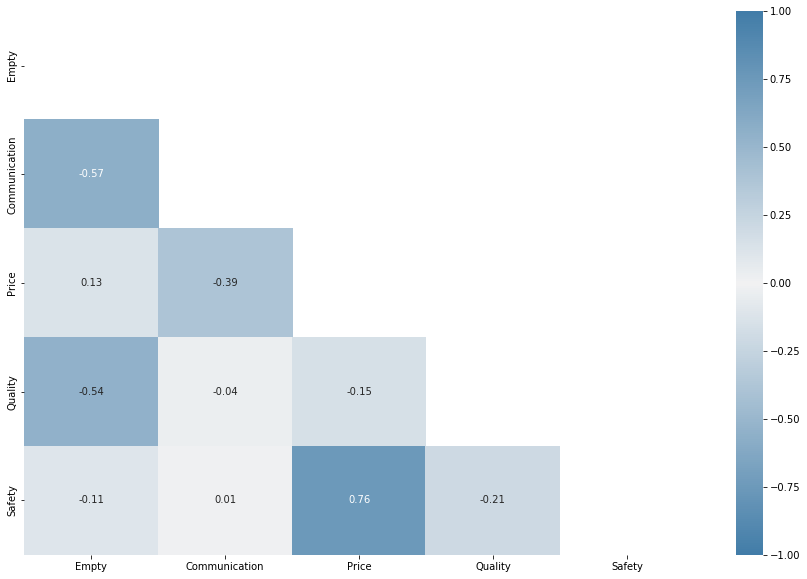

In [42]:
plt.figure(figsize=(15,10))

corr_matrix = df_copy.corr()
mask = np.tril(corr_matrix, k = -1).astype(bool)
# display(corr_matrix.where(mask))

mymap = sns.diverging_palette(240, 240, as_cmap = True)

sns.heatmap(corr_matrix.where(mask), vmin = -1, vmax = 1,
            annot=True, fmt='.2f', center=0, cmap=mymap);

In [32]:
from catboost import CatBoostClassifier
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [74]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove non-alphabetic characters
    text = re.sub(r'[^а-яА-Я\s]', '', text)
    
    # Tokenize text
    tokens = word_tokenize(text, language='russian')
    
    # Remove stop words
    stop_words = set(stopwords.words('russian'))
    tokens = [token for token in tokens if token not in stop_words]
    
#     # Stem tokens
#     stemmer = SnowballStemmer('russian')
#     tokens = [stemmer.stem(token) for token in tokens]
    
    # Join tokens back into a string
    text = ' '.join(tokens)
    
    return text

In [75]:
train_df['clean_text'] = train_df['sentence'].apply(preprocess_text)

In [76]:
from sklearn.model_selection import train_test_split
X = train_df['clean_text']
y = train_df['sentiment']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [63]:
# text = "This is a sample text to classify the tonality."
tokens = tokenizer.encode(X_train, padding=True, truncation=True, max_length=128, return_tensors='pt')

TypeError: TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]

In [40]:
with torch.no_grad():
    outputs = model(tokens)
    embeddings = outputs.last_hidden_state

In [ ]:
# Use the embeddings as input to the classification model
X_train = embeddings.numpy()
y_train = labels

# Train the CatBoost model
clf = CatBoostClassifier()
clf.fit(X_train, y_train)

In [80]:
# %pip install Mystem --user

15

In [98]:
#!c1.32
# from pymystem3 import Mystem
from tqdm import tqdm

from joblib import Parallel, delayed
import pymorphy2

batch_size = 1000

text_batch = [X_train[i: i + batch_size] for i in range(0, len(X_train), batch_size)]

def lemmatize(text):
#     m = Mystem()
    morph = pymorphy2.MorphAnalyzer()
    merged_text = "|".join(text)

    doc = []
    res = []

    for t in morph.normal_forms(merged_text):
        if t != '|':
            doc.append(t)
        else:
            res.append(doc)
            doc = []

    return res

# Вот здесь тоже немного магии :)
processed_texts = Parallel(n_jobs=-1)(delayed(lemmatize)(t) for t in tqdm(text_batch))

100%|██████████| 15/15 [00:00<00:00, 4234.10it/s]
